In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Parameters
H, W = 240, 320  # Replace with your actual image dimensions
num_clusters = 10  # Number of clusters per pixel
threshold = 10  # Distance threshold for matching a cluster
initial_weight = 1.0 / num_clusters  # Evenly distribute the initial weight

# Initialize a grayscale image frame
frame = np.random.randint(0, 256, (H, W), dtype=np.int32)
# changed data types to int32 because overflow was occurring before

# Initialize clusters for each pixel
clusters = np.zeros((H, W, num_clusters), dtype=[('centroid', np.int32), ('weight', np.float32)])
clusters['centroid'] = np.repeat(frame[:, :, np.newaxis], num_clusters, axis=2)
clusters['weight'] = initial_weight

def manhattan_distance(a, b):
    return np.abs(a - b)

def normalize_weights(clusters):
    """
    Normalize the weights of the clusters so they sum to one for each pixel.
    :param clusters: The clusters array.
    :return: The clusters with normalized weights.
    """
    sum_weights = np.sum(clusters['weight'], axis=2, keepdims=True)
    clusters['weight'] /= sum_weights
    return clusters

# Normalize the weights of the clusters
clusters = normalize_weights(clusters)

def match_and_update_clusters(new_frame, clusters, threshold, Height, Width, L=10):
    """
    Match and update clusters according to the algorithm's adaptation step.
    Args:
        new_frame: The new incoming frame (grayscale).
        clusters: The current clusters data structure.
        threshold: The threshold for matching a cluster.
        Height: The height of the frame.
        Width: The width of the frame.
        L: The parameter that controls the learning rate (the inverse of the learning rate).
    
    Returns:
        Updated clusters and a boolean array indicating matched clusters.
    """
    # Calculate the Manhattan distance to the new pixel values
    distances = np.zeros((Height, Width, clusters.shape[2]))
    for i in range(clusters.shape[2]):
        distances[:,:,i] = manhattan_distance(new_frame, clusters['centroid'][:,:,i])
    
    # Find the cluster with the minimum distance for each pixel
    min_distance_indices = np.argmin(distances, axis=2)
    min_distances = np.take_along_axis(distances, min_distance_indices[:, :, np.newaxis], axis=2).squeeze()
    
    # Determine if the minimum distances are less than the threshold
    matches = min_distances < threshold

    locs = np.zeros((Height, Width), dtype=np.int32)
    
    # Update the clusters (weights and centroids)
    for i in range(Height):
        for j in range(Width):
            if matches[i, j]:
                matched_cluster = min_distance_indices[i, j]
                locs[i, j] = matched_cluster
                # Update the weights
                for index in range(clusters.shape[2]):
                    if (index == matched_cluster):
                        clusters['weight'][i, j, index] += (1 / L) * (1 - clusters['weight'][i, j, index])
                    else:
                        clusters['weight'][i, j, index] -= (1 / L) * clusters['weight'][i, j, index]
                
                # Normalize weights to sum to 1 for all clusters
                sum_weights = np.sum(clusters['weight'][i, j])
                clusters['weight'][i, j] /= sum_weights
                
                # Update the centroid using approximation to avoid fractional centroids
                # I did this because I didn't understand the shortcut to avoid fractional centroids lmao
                clusters['centroid'][i, j, matched_cluster] += (1 / L) * (new_frame[i, j] - clusters['centroid'][i, j, matched_cluster])
                clusters['centroid'][i, j, matched_cluster] = np.clip(clusters['centroid'][i, j, matched_cluster], 0, 255)
            else:
                # Find the cluster with the smallest weight and replace it
                smallest_weight_idx = np.argmin(clusters['weight'][i, j])
                locs[i,j] = smallest_weight_idx
                clusters['centroid'][i, j, smallest_weight_idx] = new_frame[i, j]
                clusters['weight'][i, j, smallest_weight_idx] = 1 / L
                
                # Normalize weights to sum to 1 for all clusters
                sum_weights = np.sum(clusters['weight'][i, j])
                clusters['weight'][i, j] /= sum_weights
    
    return clusters, locs

def classify_pixels(clusters, locs, threshold=0.5):
    """
    Classify each pixel as foreground or background.
    
    Args:
        clusters: The clusters data structure containing centroids and weights.
        locs: the locations of the matching clusters
        threshold: The probability threshold to determine background.
    
    Returns:
        A binary mask indicating foreground and background pixels.
    """
    H, W, N = clusters['centroid'].shape  # Height, Width, and number of clusters
    
    # Initialize the probability image
    P = np.zeros((H, W))
    
    # Find the cumulative sum of weights weighted higher than the matching weight
    for i in range(H):
        for j in range(W):
            for k in range(N):
                if (clusters['weight'][i, j, k] > clusters['weight'][i, j, locs[i, j]]):
                    P[i, j] += clusters['weight'][i, j, k]
    
    # Create a binary mask based on the threshold
    binary_mask = np.zeros((H, W), dtype=np.uint8)
    binary_mask[P > threshold] = 255  # Foreground
    binary_mask[P <= threshold] = 0  # Background
    
    return binary_mask


# Simulate a new incoming frame
new_frame = np.random.randint(0, 256, (H, W), dtype=np.int32)

# Perform cluster matching and updating
test_clusters, test_locs = match_and_update_clusters(new_frame, clusters, threshold, H, W)


# Let's assume a background threshold. This value might need tuning for different scenarios
background_threshold = 0.100001  # Example threshold

# Perform classification
binary_mask = classify_pixels(clusters, test_locs, background_threshold)
# print(binary_mask.shape, binary_mask.dtype)

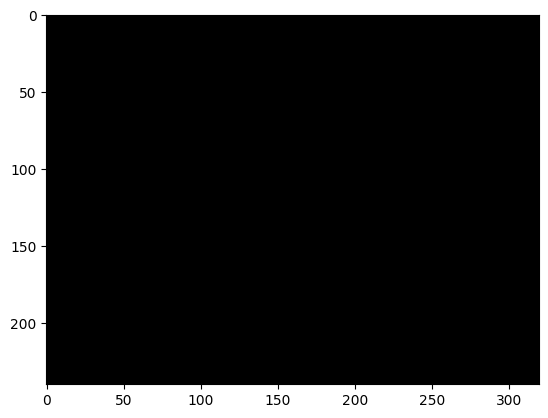

In [13]:
plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

In [14]:

def postprocess_segmentation(binary_mask, min_area_threshold=50):
    """
    Post-process the binary segmentation mask according to the described algorithm.
    
    Args:
        binary_mask: Binary mask with foreground as white (255) and background as black (0).
        min_area_threshold: Minimum area threshold to keep a blob.
    
    Returns:
        Cleaned binary mask.
    """

    kernel_open = np.ones((2,2), np.uint8)
    opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_open)
    # Join pixels that are separated by a single gap
    # kernel = np.ones((2,2), np.uint8)
    # closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    # Find contours from the binary mask
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask to draw the retained contours
    mask = np.zeros_like(binary_mask)
    
    # Filter out small contours and draw the rest on the mask
    for contour in contours:
        if cv2.contourArea(contour) > min_area_threshold:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    return mask

#def postprocess_segmentation(binary_mask):
    """
    Post-process the binary segmentation mask.
    :param binary_mask: Binary mask with foreground as white (255) and background as black (0).
    :return: Cleaned binary mask.
    """
    # Define kernel for morphological operations
    kernel = np.ones((3,3), np.uint8)
    
    # Remove noise (small white spots in the background)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Close small holes in the foreground objects (small black spots in the foreground)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Optionally, remove small blobs by setting a minimum area threshold
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
    
    # min_area_threshold = 50  # minimum area in pixels for a blob to be kept
    # for i in range(1, num_labels):  # label 0 is the background label, so we start from 1
    #     if stats[i, cv2.CC_STAT_AREA] < min_area_threshold:
    #         closing[labels == i] = 0
    
    return closing


# Assume 'binary_mask' is the binary mask from the classification step
# Apply the post-processing routine to clean up the segmentation result
cleaned_binary_mask = postprocess_segmentation(binary_mask)


In [15]:
def initialize_clusters(cap, num_clusters_per_pixel, frame_height, frame_width):
    # Initialize the centroids array
    centroids = np.zeros((frame_height, frame_width, num_clusters_per_pixel), dtype=np.uint8)
    weights = np.full((frame_height, frame_width, num_clusters_per_pixel), 1.0 / num_clusters_per_pixel, dtype=np.float32)
    
    # Read the first n frames to set as initial centroids
    for c in range(num_clusters_per_pixel):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Not enough frames in video to initialize clusters.")
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        centroids[:, :, c] = gray_frame
    
    return centroids, weights

In [16]:
# Actual code to run it

# Video processing setup
video_path = 'titanic_test.mp4'
cap = cv2.VideoCapture(video_path)
frame_height, frame_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H, W = frame_height, frame_width
num_clusters_per_pixel = 5
threshold = 20

# length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print( length )

initial_centroids, initial_weights = initialize_clusters(cap, num_clusters_per_pixel, frame_height, frame_width)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Prepare video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 30.0, (frame_width, frame_height), isColor=False)

# Initialize clusters structure
clusters = np.zeros((frame_height, frame_width, num_clusters_per_pixel),
                    dtype=[('centroid', np.int32), ('weight', np.float32)])
clusters['centroid'] = initial_centroids
clusters['weight'] = initial_weights
frame_num = 0
while cap.isOpened():
    frame_num+=1
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Assuming the existence of matching, adaptation, classification, and post-processing functions
    clusters, locs = match_and_update_clusters(gray_frame, clusters, threshold, gray_frame.shape[0], gray_frame.shape[1], 100)
    # Normalization happens in match_and_update_clusters
    binary_mask = classify_pixels(clusters, locs, 0.6)
    cleaned_binary_mask = postprocess_segmentation(binary_mask)

    print(f'\rCurrent Frame: {frame_num} / {total_frames}', end='')
    out.write(cleaned_binary_mask)  # Save the processed frame
    cv2.imshow('Pre-Processed Frame', binary_mask)
    cv2.imshow('Post-Processed Frame', cleaned_binary_mask)
    cv2.imshow('Raw Frame', gray_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

print('\nFinished\n')
cap.release()
out.release()
cv2.destroyAllWindows()

Current Frame: 271 / 276
Finished

